# EDA

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.graphics.gofplots import qqplot

df = pd.read_csv('../src/kc_house_data.csv')

In [2]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
column_names = df.columns
column_names

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
#this takes a while to run, but it is a pairplot of correlations for all existing features

#sns.pairplot(data)

In [5]:
prices = df.price
prices.mean()

540296.5735055795

In [6]:
df.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

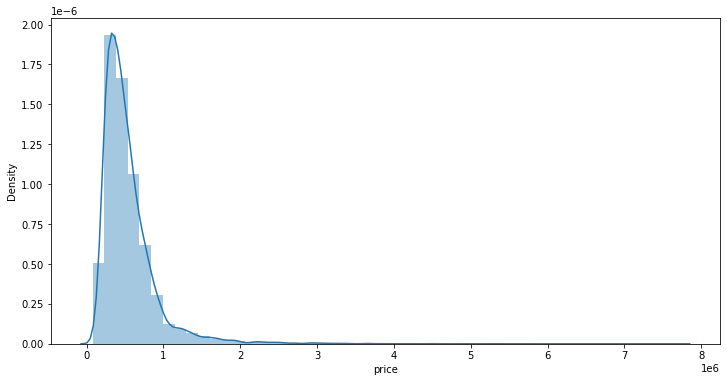

In [7]:
##distribution plot of home prices without scaling/standardization

fig, ax = plt.subplots(figsize = (12,6))

sns.distplot(prices)

In [8]:
#checking rooms data, seems like there is an outlier with 33 bedrooms - worth investigating further
df[['bedrooms', 'bathrooms']].describe()

,bedrooms,bathrooms
count,21597.000000,21597.000000
mean,3.373200,2.115826
std,0.926299,0.768984
min,1.000000,0.500000
25%,3.000000,1.750000
50%,3.000000,2.250000
75%,4.000000,2.500000
max,33.000000,8.000000


In [9]:
df[df['bedrooms'] == 33.00]

# upon looking up the parcel id, this seems to be an entry error - likely to be 3 bedrooms but we will drop this row from
# the model

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [10]:
# checking for NaN values - waterfront has a lot of missing data so unless we split this data into two models,
# it will probably be dropped
# yr_renovated and view will be dropped
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [11]:
##features to drop for inference: id, sqft_lot15, sqft_lot, view, lat, long
##rows to drop/separate: condition < 3, grade < 6

##additional features: price_per_sqft, location categorical, single-level categorical, 
##waterfront categorical, sale month categorical,

## potential splits - luxury homes - condition > 3 and grade 10-13 - likely to be able to include waterfront here
##                    non-luxury homes - condition > 3 and grade 6-9

In [12]:
df.sqft_basement.describe()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object

In [13]:
##replacing string '?' values with np.nan as float values

df['sqft_basement'] = df['sqft_basement'].replace("?", np.nan)
df['sqft_basement'] = df['sqft_basement'].astype('float64')

In [14]:
## most homes are in condition range 3-5
## because we are focusing on residential realty and not fixer-uppers, we will drop conditions 1 & 2

df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [15]:
#investigaing zipcode column to see how many possible zipcodes and values exist by area

df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [16]:
#initial correlation matrix to look for multicollinearity

df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,-0.004548,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.325008,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.302683,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.282693,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.434576,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.015533,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,-0.245144,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,0.090200,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,0.276521,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,0.170972,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [17]:
# first model
# note that here, the predictor values do have a high correlation

formula1 = 'price ~ sqft_living + sqft_living15 + bathrooms + bedrooms'
first_model = ols(formula = formula1, data = df).fit()
first_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5671.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:28:14   Log-Likelihood:            -2.9964e+05
No. Observations:               21597   AIC:                         5.993e+05
Df Residuals:                   21592   BIC:                         5.993e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.124e+04   7785.367      2.728      0.006    5981.914    3.65e+04
sqft_living     274.6320      3.849     71.355      0.000     267.088     282.176
sqft_living15    60.3673      3.909     15.445      0.000      52.706      68.028
bathrooms      7230.3124   3504.191      2.063      0.039     361.839    1.41e+04
bedrooms      -5.558e+04   2342.834    -23.725      0.000   -6.02e+04    -5.1e+04
==============================================================================
Omnibus:                    15088.233   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           601249.714
Skew:                           2.874   Prob(JB):                         0.00
Kurtosis:                      28.201   Cond. No.                     1.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

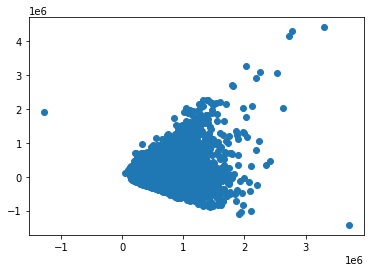

In [18]:
## checking residuals - they are not homoskedatic, so this is unlikely to be an accurate model

x = first_model.predict(df[['sqft_living','sqft_living15','bathrooms','bedrooms']])
y = first_model.resid
plt.scatter(x, y);

In [19]:
first_model.resid.max()
x.max()

df.loc[x[x == x.min()].index] ##the falsely-labeled home is one of the biggest outliers in this data set

#data.loc[y[y == y.max()].index]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


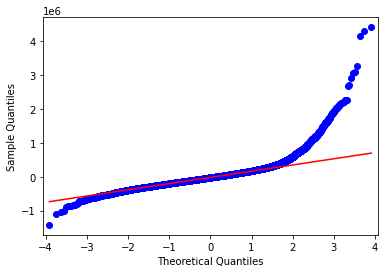

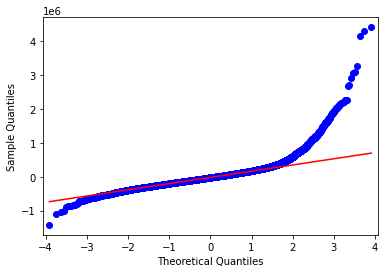

In [20]:
qqplot(first_model.resid, line = 'q')

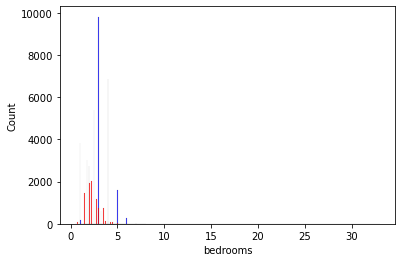

In [21]:
#looking at value distribution of bedrooms and bathrooms
sns.histplot(df['bedrooms'], color = 'b')

sns.histplot(df['bathrooms'], color = 'r');

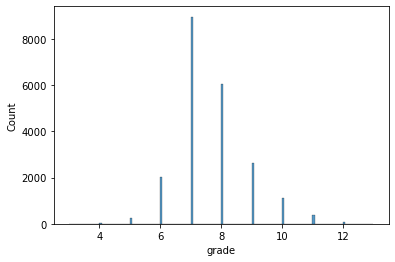

In [22]:
df.grade.value_counts().sort_values()

sns.histplot(df.grade);

##the home grades data seems to be mostly normally distributed with the bulk in 6-9

In [23]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [24]:
df['price_per_sqft'].describe()

count    21597.000000
mean       264.143368
std        110.000061
min         87.588235
25%        182.291667
50%        244.644550
75%        318.333333
max        810.138889
Name: price_per_sqft, dtype: float64

In [25]:
df['sqft_above'] = df['sqft_above'].astype('float64')

In [26]:
df['yard_size'] = df['sqft_lot']-df['sqft_above']-df['sqft_basement']

##this did not yield any particularly interesting results except that 767 of the listings have a negative yard size.
##investingating this using the assessor's website, it seems like those are multi-unit homes
##could be worth subsetting this as well

df.yard_size.value_counts()

 4780.0     20
 3420.0     20
 2910.0     20
 2570.0     19
 3120.0     19
            ..
 2924.0      1
-517.0       1
 7096.0      1
 38057.0     1
 2856.0      1
Name: yard_size, Length: 10578, dtype: int64

In [27]:
df[df['yard_size'] <= 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,yard_size
63,9528102996,12/7/2014,549000.0,3,1.75,1540,1044,3.0,0.0,0.0,...,0.0,2014,0.0,98115,47.6765,-122.320,1580,3090,356.493506,-496.0
116,3362400431,6/26/2014,518500.0,3,3.50,1590,1102,3.0,0.0,0.0,...,0.0,2010,0.0,98103,47.6824,-122.347,1620,3166,326.100629,-488.0
175,7234600798,2/10/2015,425000.0,3,2.50,1120,1100,2.0,0.0,0.0,...,300.0,2008,0.0,98122,47.6106,-122.310,1590,1795,379.464286,-20.0
406,7821200390,8/6/2014,450000.0,3,2.00,1290,1213,3.0,0.0,0.0,...,0.0,2001,0.0,98103,47.6609,-122.344,1290,3235,348.837209,-77.0
547,7899800860,3/19/2015,259950.0,2,2.00,1070,649,2.0,0.0,0.0,...,350.0,2008,0.0,98106,47.5213,-122.357,1070,928,242.943925,-421.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21579,1972201967,10/31/2014,520000.0,2,2.25,1530,981,3.0,0.0,0.0,...,50.0,2006,NaN,98103,47.6533,-122.346,1530,1282,339.869281,-549.0
21585,5100403806,4/7/2015,467000.0,3,2.50,1425,1179,3.0,0.0,0.0,...,0.0,2008,0.0,98125,47.6963,-122.318,1285,1253,327.719298,-246.0
21588,9834201367,1/26/2015,429000.0,3,2.00,1490,1126,3.0,0.0,0.0,...,0.0,2014,0.0,98144,47.5699,-122.288,1400,1230,287.919463,-364.0
21591,2997800021,2/19/2015,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,...,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265,362.595420,-16.0


In [28]:
##using a zipcode map, I created a list of zipcodes that are outside of 'incorporated areas' - meaning these areas are
##outside of a municipality and do not have municipal services but also probably lower taxes
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98029, 98014, 98077, 98053, 98010, 98070]

In [29]:
unincorporated_zipcodes = list(set(unincorporated_zipcodes))

In [30]:
## we wanted to explore whether the month of sale impacted the price, so we first created a month_sold feature
df['month_sold'] = df['date'].map(lambda x: x.split('/')[0]).astype('int64')

In [31]:
## created a season categorical

winter = [12,1,2]
fall = [9,10,11]
summer = [6,7,8]
spring = [3,4,5]
season_vals = []
for month in df['month_sold']:
    if month in winter:
        season_vals.append('winter')
    elif month in fall:
        season_vals.append('fall')
    elif month in summer:
        season_vals.append('summer')
    else:
        season_vals.append('spring')
df['season_sold'] = pd.DataFrame(season_vals)
df['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

In [32]:
##created a binary variable for whether the property was in a municipal area or not - 1 means that it is not
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 1, 0)

In [33]:
## there are approximately 2800 homes outside of municipal areas, ranging from $80k to $2.3mil

df[df['unincorporated']  == 1].sort_values('price')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,yard_size,month_sold,season_sold,unincorporated
465,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,0.0,...,98014,47.6499,-121.909,1200,7500,186.046512,4620.0,5,spring,1
17183,5111400086,5/12/2014,110000.0,3,1.00,1250,53143,1.0,0.0,0.0,...,98038,47.4235,-122.051,1820,217800,88.000000,51893.0,5,spring,1
8073,1545807810,10/21/2014,118000.0,1,1.00,670,7957,1.0,0.0,0.0,...,98038,47.3594,-122.056,1600,7957,176.119403,7287.0,10,fall,1
5522,3821200050,6/4/2014,119500.0,3,1.00,1170,11000,1.0,0.0,0.0,...,98019,47.7346,-121.983,1590,10894,102.136752,9830.0,6,summer,1
3389,1917300025,1/27/2015,122000.0,2,1.00,860,6000,1.0,0.0,0.0,...,98022,47.2109,-121.985,1300,6000,141.860465,5140.0,1,winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11859,8835800350,1/12/2015,1950000.0,4,3.25,7420,167869,2.0,0.0,3.0,...,98045,47.4548,-121.764,5610,169549,262.803235,160449.0,1,winter,1
6685,2624089007,3/20/2015,2000000.0,2,2.50,3900,920423,2.0,0.0,0.0,...,98065,47.5371,-121.756,2720,411962,512.820513,916523.0,3,spring,1
8436,125069038,11/25/2014,2140000.0,4,3.75,5150,453895,2.0,NaN,3.0,...,98053,47.6795,-121.991,2500,215186,415.533981,448745.0,11,fall,1
11736,3629940160,3/11/2015,2200000.0,5,4.50,5840,17168,2.0,0.0,0.0,...,98029,47.5457,-121.991,4850,15017,376.712329,11328.0,3,spring,1


In [34]:
##checking home square footage by where in King county they are
neighbor_sqft_means = df.groupby('unincorporated')['sqft_living15'].mean()

##investigaing per square foot pricing based on location
location_per_sqft = df.groupby('unincorporated')['price_per_sqft'].mean()

##more granularity on pricing by specific zipcodes -- seems like some are vastly different from others, as expected
zipcode_per_sqft = df.groupby('zipcode')['price_per_sqft'].mean()

neighbor_sqft_means, location_per_sqft, zipcode_per_sqft

(unincorporated
 0    1953.680026
 1    2200.440860
 Name: sqft_living15, dtype: float64,
 unincorporated
 0    270.539063
 1    222.627922
 Name: price_per_sqft, dtype: float64,
 zipcode
 98001    151.347966
 98002    151.174091
 98003    157.113414
 98004    475.609615
 98005    314.966998
             ...    
 98177    292.982095
 98178    189.172528
 98188    169.007306
 98198    178.434333
 98199    376.659850
 Name: price_per_sqft, Length: 70, dtype: float64)

In [35]:
##here I wanted to look at distribution of square foot pricing by zipcodes 
## most are in the 200-300 per sqft range, with a few over 400
grouped_zips = df.groupby('zipcode')['price_per_sqft'].mean()
ranges = [0,100,200,300,400,500,600]

grouped_zips.groupby(pd.cut(grouped_zips.values, ranges)).count()

(0, 100]       0
(100, 200]    18
(200, 300]    32
(300, 400]    13
(400, 500]     6
(500, 600]     1
Name: price_per_sqft, dtype: int64

In [36]:
##defines a function that returns the value of the zipcode_per_sqft subset

def zipcode_price(zipcode):
    try:
        return zipcode_per_sqft.loc[zipcode]
    except:
        return np.nan  
    
##testing a value and checking to make sure it is an int or float type

zipcode_per_sqft.loc[98178], type(df['zipcode'][1])

(189.17252830749558, numpy.int64)

In [37]:
##created a new feature in the dataframe to apply a mean zipcode price to each row

df['zip_psqft'] = df['zipcode'].apply(zipcode_price)


##created a category variable for zipcode prices to be able to group properties
conditions = [(df['zip_psqft'] >= 100) & (df['zip_psqft'] < 200),
              (df['zip_psqft'] >= 200) & (df['zip_psqft'] < 300),
              (df['zip_psqft'] >= 300) & (df['zip_psqft'] < 400),
              (df['zip_psqft'] >= 400) & (df['zip_psqft'] < 500),
               df['zip_psqft'] >= 500]

choices = [1, 2, 3, 4, 5]


df['location_cost'] = np.select(conditions, choices, default = np.nan)

In [38]:
##created a list of zipcodes by price range
zips1 = set(list(df[df['location_cost'] == 1.0]['zipcode'].values))
zips2 = set(list(df[df['location_cost'] == 2.0]['zipcode'].values))
zips3 = set(list(df[df['location_cost'] == 3.0]['zipcode'].values))
zips4 = set(list(df[df['location_cost'] == 4.0]['zipcode'].values))
zips5 = set(list(df[df['location_cost'] == 5.0]['zipcode'].values))

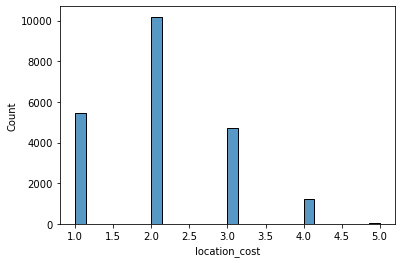

In [39]:
##investigating the distribution of zipcodes by price -- seems that most are under $400/sqft
## this distribution is slightly skewed and could be normalized

sns.histplot(df['location_cost']);

In [40]:
##created one more categorical feature for the decade of construction because categoricals for each year
## could substantially contribute to overfitting

conditions1 = [(df['yr_built'] >= 1900) & (df['yr_built'] < 1910),
               (df['yr_built'] >= 1910) & (df['yr_built'] < 1920),
               (df['yr_built'] >= 1920) & (df['yr_built'] < 1930),
               (df['yr_built'] >= 1930) & (df['yr_built'] < 1940),
               (df['yr_built'] >= 1940) & (df['yr_built'] < 1950),
               (df['yr_built'] >= 1950) & (df['yr_built'] < 1960),
               (df['yr_built'] >= 1960) & (df['yr_built'] < 1970),
               (df['yr_built'] >= 1970) & (df['yr_built'] < 1980),
               (df['yr_built'] >= 1980) & (df['yr_built'] < 1990),
               (df['yr_built'] >= 1990) & (df['yr_built'] < 2000),
               (df['yr_built'] >= 2000) & (df['yr_built'] < 2010),
               (df['yr_built'] >= 2010) & (df['yr_built'] < 2020)]

choices1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

df['decade_built'] = np.select(conditions1, choices1, np.nan)

In [41]:
##dropping the 33-bedroom outlier (input error)
dropping = df[df['bedrooms'] == 33].index
df.drop(dropping, inplace = True)

##dropping several high-bedroom outliers due to their average price per sqft
##4 total rows, each of which look like multi-unit rental properties
outliers = df[df['bedrooms'].isin(list(range(10,13)))].index

df.drop(outliers, inplace = True)

# Final dataframe before selecting features for OLS modeling

In [42]:
## this dataframe contains homes that are 3 or above, condition-wise
## because we are focusing on livable homes, not fixer-uppers

data = df[df['condition'] >= 3]

## data will also be subset to exclude all homes outside of 3 standard deviations of the $264/sqft price 

data = data[~(np.abs(stats.zscore(data['price_per_sqft'])) > 3)]

## there are still NaN values in this dataframe, but they will be addressed on a subsetting basis
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,price_per_sqft,yard_size,month_sold,season_sold,unincorporated,zip_psqft,location_cost,decade_built
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1340,5650,188.050847,4470.0,10,fall,0,189.172528,1.0,5.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1690,7639,209.338521,4672.0,12,winter,0,282.680191,2.0,5.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,2720,8062,233.766234,9230.0,2,winter,0,225.145368,2.0,3.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1360,5000,308.163265,3040.0,12,winter,0,337.245108,3.0,6.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1800,7503,303.571429,6400.0,2,winter,0,265.686627,2.0,8.0


In [43]:
data.location_cost.value_counts()

2.0    10025
1.0     5378
3.0     4546
4.0     1084
5.0       30
Name: location_cost, dtype: int64

## Subsetting for Luxury Homes Model

In [44]:
luxury_df = data[data['grade'] >= 10]

luxury_df.info(), luxury_df.isna().sum()
## as you can see here, there are considerably fewer null values in the 'waterfront' feature for luxury homes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1549 entries, 5 to 21584
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1549 non-null   int64  
 1   date            1549 non-null   object 
 2   price           1549 non-null   float64
 3   bedrooms        1549 non-null   int64  
 4   bathrooms       1549 non-null   float64
 5   sqft_living     1549 non-null   int64  
 6   sqft_lot        1549 non-null   int64  
 7   floors          1549 non-null   float64
 8   waterfront      1390 non-null   float64
 9   view            1543 non-null   float64
 10  condition       1549 non-null   int64  
 11  grade           1549 non-null   int64  
 12  sqft_above      1549 non-null   float64
 13  sqft_basement   1521 non-null   float64
 14  yr_built        1549 non-null   int64  
 15  yr_renovated    1269 non-null   float64
 16  zipcode         1549 non-null   int64  
 17  lat             1549 non-null   

(None,
 id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront        159
 view                6
 condition           0
 grade               0
 sqft_above          0
 sqft_basement      28
 yr_built            0
 yr_renovated      280
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 price_per_sqft      0
 yard_size          28
 month_sold          0
 season_sold         0
 unincorporated      0
 zip_psqft           0
 location_cost       0
 decade_built        0
 dtype: int64)

## Luxury Home OLS models using different combinations of features

In [45]:
## feature pruning for an inferential model 
## five current potential features have NaN values. View, basement sqft, and year renovated will be dropped.
## NaN values for waterfront and yard size will be dropped because there is not an accurate way to predict this data
to_drop_cols = ['date', 'view', 'yr_renovated', 'zipcode', 'lat', 'long', 'price_per_sqft', 'month_sold', 'zip_psqft', 'sqft_above', 'yr_built']
lux_ols_base = luxury_df.drop(columns = to_drop_cols, axis =1)

lux_ols_base.dropna(inplace = True) ##reduced the data to 1440 rows from 1633
lux_ols_base.corr() ##correlation matrix to explore multicollinearity issues

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,sqft_living15,sqft_lot15,yard_size,unincorporated,location_cost,decade_built
id,1.000000,-0.080944,-0.023215,-0.110534,-0.070457,-0.148751,-0.028410,0.017633,-0.055143,-0.053072,0.033088,0.044548,-0.109748,-0.148100,-0.058748,-0.048770,0.042203
price,-0.080944,1.000000,0.288616,0.483073,0.616887,-0.015588,0.027176,0.247039,0.210748,0.491545,0.410234,0.183494,-0.018212,-0.024181,-0.166385,0.579249,-0.237431
bedrooms,-0.023215,0.288616,1.000000,0.462703,0.474590,-0.041269,0.098462,-0.060771,0.058311,0.165608,0.246530,0.204207,-0.034231,-0.047944,-0.055267,0.134663,-0.058377
bathrooms,-0.110534,0.483073,0.462703,1.000000,0.689264,0.089999,0.132605,0.010624,-0.028782,0.388276,0.370060,0.200684,0.090091,0.080634,-0.002205,0.135016,0.100755
sqft_living,-0.070457,0.616887,0.474590,0.689264,1.000000,0.165150,0.081870,0.097217,0.040934,0.552244,0.481115,0.413941,0.169588,0.151639,0.051763,0.064127,0.006650
sqft_lot,-0.148751,-0.015588,-0.041269,0.089999,0.165150,1.000000,-0.055822,-0.026600,-0.032489,0.084421,-0.015632,-0.045461,0.713828,0.999906,0.346937,-0.180750,0.067517
floors,-0.028410,0.027176,0.098462,0.132605,0.081870,-0.055822,1.000000,-0.006323,-0.108437,0.064441,-0.293223,-0.070208,-0.054038,-0.057081,0.009428,0.049736,0.093543
waterfront,0.017633,0.247039,-0.060771,0.010624,0.097217,-0.026600,-0.006323,1.000000,-0.024729,0.115655,0.145416,-0.027711,-0.016824,-0.028008,-0.059433,-0.021739,-0.029654
condition,-0.055143,0.210748,0.058311,-0.028782,0.040934,-0.032489,-0.108437,-0.024729,1.000000,-0.023564,0.172343,0.054133,-0.021146,-0.033128,-0.082960,0.183112,-0.487695
grade,-0.053072,0.491545,0.165608,0.388276,0.552244,0.084421,0.064441,0.115655,-0.023564,1.000000,0.164451,0.372738,0.093637,0.076945,0.000299,0.051916,0.015322


In [46]:
##the home's grade strongly correlates with square footage 
##sqft_living correlates strongly with number of bathrooms and somewhat strongly with bedrooms
##sqft_living correlates strongly with basement sqft
##sqft_lot and sqft_lot15 strongly correlate and so does yard size but that is an engineered feature

In [47]:
lux_ols_base.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'yard_size', 'season_sold',
       'unincorporated', 'location_cost', 'decade_built'],
      dtype='object')

In [48]:
##Initialized dummy variables for all categorical features
dummy_list = ['unincorporated','waterfront','bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'season_sold', 'location_cost', 'decade_built']


inc_dummies = pd.get_dummies(lux_ols_base['unincorporated'].astype(int), prefix='city', drop_first=True)
water_dummies = pd.get_dummies(lux_ols_base['waterfront'].astype(int), prefix='water', drop_first=True)
bed_dummies = pd.get_dummies(lux_ols_base['bedrooms'].astype(int), prefix='bed', drop_first=True)
bath_dummies = pd.get_dummies(lux_ols_base['bathrooms'].astype(int), prefix = 'bath', drop_first = True)
floor_dummies = pd.get_dummies(lux_ols_base['floors'].astype(int), prefix='floor', drop_first=True)
cond_dummies = pd.get_dummies(lux_ols_base['condition'].astype(int), prefix='cond', drop_first=True)
grade_dummies = pd.get_dummies(lux_ols_base['grade'].astype(int), prefix='grade', drop_first=True)
season_dummies = pd.get_dummies(lux_ols_base['season_sold'], prefix='month', drop_first=True)
loc_dummies = pd.get_dummies(lux_ols_base['location_cost'].astype(int), prefix='loc', drop_first=True)
built_dummies = pd.get_dummies(lux_ols_base['decade_built'].astype(int), prefix='built', drop_first=True)

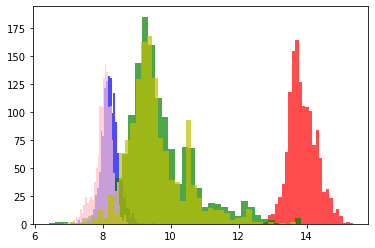

In [49]:
##Initialized log-transformed variables for all continuous variables without negative values

log_price = np.log(lux_ols_base['price'])
log_sqft_living = np.log(lux_ols_base['sqft_living'])
log_sqft_lot = np.log(lux_ols_base['sqft_lot'])
log_sqft_living15 = np.log(lux_ols_base['sqft_living15'])
log_sqft_lot15 = np.log(lux_ols_base['sqft_lot15'])

plt.hist(log_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(log_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(log_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(log_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(log_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

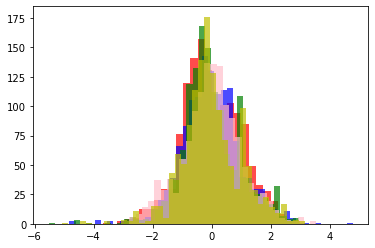

In [50]:
##Performed a Power Transformation on all continuous variable with no negative values

power = PowerTransformer()

power_price = power.fit_transform(np.array(log_price).reshape(-1, 1))
power_sqft_living = power.fit_transform(np.array(log_sqft_living).reshape(-1, 1))
power_sqft_lot = power.fit_transform(np.array(log_sqft_lot).reshape(-1, 1))
power_sqft_living15 = power.fit_transform(np.array(log_sqft_living15).reshape(-1, 1))
power_sqft_lot15 = power.fit_transform(np.array(log_sqft_lot15).reshape(-1, 1))

plt.hist(power_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(power_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(power_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(power_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(power_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

## Luxury Model 1

In [51]:
lux_ols1 = lux_ols_base.drop(columns = ['sqft_living', 'sqft_lot'], axis = 1) ##dropping multicollinear continuous vars

##Addressing categorical features
lux_ols1 = lux_ols1.drop(columns = dummy_list, axis = 1) ##dropping original categoricals
lux_ols1 = pd.concat([lux_ols1, inc_dummies, water_dummies, bed_dummies, bath_dummies, floor_dummies, cond_dummies, grade_dummies, season_dummies, loc_dummies, built_dummies], axis = 1)


##Scaling all features
ss = StandardScaler()

scaled_lux_ols1 = pd.DataFrame(ss.fit_transform(lux_ols1))
scaled_lux_ols1.columns = lux_ols1.columns

scaled_lux_ols1

,id,price,sqft_basement,sqft_living15,sqft_lot15,yard_size,city_1,water_1,bed_2,bed_3,...,built_2,built_3,built_4,built_5,built_6,built_7,built_8,built_9,built_10,built_11
0,1.001116,0.118450,1.610947,1.995995,1.529452,0.901392,2.299068,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,1.512199,-0.303436
1,-0.965628,-0.237747,1.865447,0.419455,0.282901,0.217657,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,4.236088,-0.452711,-0.635053,-0.661288,-0.303436
2,-0.362483,-0.626752,0.877389,0.047750,0.205808,0.035296,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,2.208916,-0.635053,-0.661288,-0.303436
3,0.243251,-0.125264,-0.679551,-0.875102,-0.363332,-0.349932,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,1.512199,-0.303436
4,-0.852721,-0.912647,-0.679551,-0.272685,0.205433,-0.055204,2.299068,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,1.574672,-0.661288,-0.303436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,-1.310260,0.999570,0.383360,-1.298077,-0.273777,-0.319208,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,-0.661288,3.295583
1360,1.457380,-0.715801,0.637859,-1.169903,-0.434272,-0.366215,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,1.512199,-0.303436
1361,1.067443,0.099703,2.015152,1.739647,-0.268120,-0.327210,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,1.512199,-0.303436
1362,1.495049,-0.144011,-0.679551,-0.221415,-0.329109,-0.334717,-0.434959,-0.136641,-0.125047,-0.524182,...,-0.108947,-0.121988,-0.07681,-0.142107,-0.16698,-0.236067,-0.452711,-0.635053,1.512199,-0.303436


In [52]:
target = 'price'
x_cols = scaled_lux_ols1.drop(columns = 'price', axis = 1).columns
predictors = '+'.join(x_cols)

lux_formula = target + '~' + predictors

lux_model1 = ols(formula = lux_formula, data = scaled_lux_ols1).fit()

lux_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     78.02
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:28:23   Log-Likelihood:                -1038.6
No. Observations:                1364   AIC:                             2171.
Df Residuals:                    1317   BIC:                             2416.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.441e-16      0.014   3.11e-14      1.000      -0.028       0.028
id               -0.0189      0.015     -1.261      0.207      -0.048       0.010
sqft_basement     0.1024      0.019      5.490      0.000       0.066       0.139
sqft_living15     0.1462      0.017      8.362      0.000       0.112       0.181
sqft_lot15       -0.0227      0.021     -1.072      0.284      -0.064       0.019
yard_size         0.0831      0.021      3.896      0.000       0.041       0.125
city_1           -0.0214      0.016     -1.298      0.195      -0.054       0.011
water_1           0.2301      0.015     15.335      0.000       0.201       0.260
bed_2             0.0757      0.067      1.123      0.262      -0.057       0.208
bed_3             0.3137      0.220      1.428      0.154      -0.117       0.745
bed_4             0.3976      0.265      1.503      0.133      -0.121       0.917
bed_5             0.3069      0.203      1.515      0.130      -0.090       0.704
bed_6             0.1306      0.080      1.639      0.102      -0.026       0.287
bed_7             0.0632      0.044      1.438      0.151      -0.023       0.149
bed_8             0.0391      0.025      1.534      0.125      -0.011       0.089
bed_9            -0.0228      0.021     -1.096      0.273      -0.064       0.018
bath_2            0.0760      0.068      1.123      0.262      -0.057       0.209
bath_3            0.1560      0.068      2.283      0.023       0.022       0.290
bath_4            0.2085      0.051      4.118      0.000       0.109       0.308
bath_5            0.0993      0.024      4.125      0.000       0.052       0.147
bath_6            0.1308      0.019      6.881      0.000       0.093       0.168
bath_8            0.0218      0.017      1.309      0.191      -0.011       0.054
floor_2          -0.0068      0.018     -0.370      0.711      -0.043       0.029
floor_3          -0.0137      0.017     -0.804      0.422      -0.047       0.020
cond_4            0.0520      0.016      3.196      0.001       0.020       0.084
cond_5            0.1128      0.016      6.879      0.000       0.081       0.145
grade_11          0.1470      0.016      9.064      0.000       0.115       0.179
grade_12          0.2220      0.017     13.330      0.000       0.189       0.255
grade_13          0.1846      0.015     12.281      0.000       0.155       0.214
month_spring      0.0463      0.019      2.456      0.014       0.009       0.083
month_summer     -0.0123      0.019     -0.651      0.515      -0.049       0.025
month_winter      0.0137      0.018      0.776      0.438      -0.021       0.048
loc_2             0.2694      0.027      9.988      0.000       0.216       0.322
loc_3             0.4818      0.026     18.710      0.000       0.431       0.532
loc_4             0.5788      0.023     25.213   

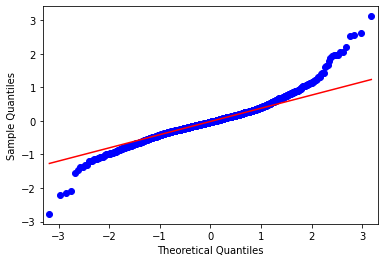

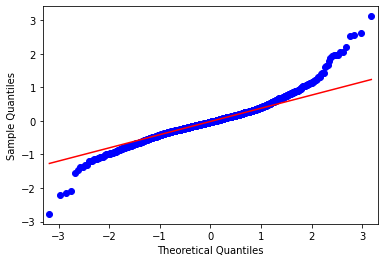

In [53]:
qqplot(lux_model1.resid, line = 'q')

## Luxury Model 2

power_price = minmax.fit_transform(np.array(log_price).reshape(-1, 1))
power_sqft_living = minmax.fit_transform(np.array(log_sqft_living).reshape(-1, 1))
power_sqft_lot = minmax.fit_transform(np.array(log_sqft_lot).reshape(-1, 1))
power_sqft_living15 = minmax.fit_transform(np.array(log_sqft_living15).reshape(-1, 1))
power_sqft_lot = minmax.fit_transform(np.array(log_sqft_lot15).reshape(-1, 1))

In [54]:
lux_ols2 = lux_ols_base[['price', 'sqft_living', 'waterfront', 'condition', 'sqft_lot15', 'unincorporated', 'location_cost', 'decade_built']]

lux_ols2 = lux_ols2.drop(columns = ['decade_built','waterfront', 'condition', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols2 = pd.concat([lux_ols2, built_dummies, water_dummies, cond_dummies, inc_dummies, loc_dummies], axis = 1)


lux_ols2['price'] = power_price
lux_ols2['sqft_living'] = power_sqft_living
lux_ols2['sqft_lot15'] = power_sqft_lot15


In [55]:
target = 'price'
x_cols = lux_ols2.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula2 = target + '~' + predictors

lux_model2 = ols(formula = formula2, data = lux_ols2).fit()
lux_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     191.8
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:28:24   Log-Likelihood:                -989.82
No. Observations:                1364   AIC:                             2024.
Df Residuals:                    1342   BIC:                             2138.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3666      0.150     -9.096      0.000      -1.661      -1.072
sqft_living     0.5043      0.016     32.169      0.000       0.474       0.535
sqft_lot15      0.0711      0.018      3.897      0.000       0.035       0.107
built_1         0.0881      0.187      0.472      0.637      -0.278       0.454
built_2         0.1109      0.184      0.604      0.546      -0.249       0.471
built_3         0.2824      0.175      1.614      0.107      -0.061       0.626
built_4         0.1486      0.222      0.668      0.504      -0.287       0.585
built_5        -0.1189      0.168     -0.709      0.479      -0.448       0.210
built_6        -0.1707      0.162     -1.056      0.291      -0.488       0.146
built_7        -0.3285      0.151     -2.180      0.029      -0.624      -0.033
built_8        -0.2023      0.146     -1.389      0.165      -0.488       0.083
built_9        -0.1339      0.145     -0.926      0.355      -0.418       0.150
built_10       -0.0704      0.143     -0.492      0.623      -0.351       0.210
built_11        0.0466      0.148      0.315      0.753      -0.244       0.337
water_1         1.1874      0.104     11.465      0.000       0.984       1.391
cond_4          0.1344      0.045      2.968      0.003       0.046       0.223
cond_5          0.4254      0.079      5.360      0.000       0.270       0.581
city_1         -0.1684      0.043     -3.930      0.000      -0.252      -0.084
loc_2           1.2705      0.052     24.503      0.000       1.169       1.372
loc_3           1.9405      0.060     32.475      0.000       1.823       2.058
loc_4           2.4232      0.068     35.625      0.000       2.290       2.557
loc_5           2.8046      0.160     17.485      0.000       2.490       3.119
==============================================================================
Omnibus:                       45.865   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.229
Skew:                          -0.057   Prob(JB):                     2.12e-26
Kurtosis:                       4.438   Cond. No.                         46.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

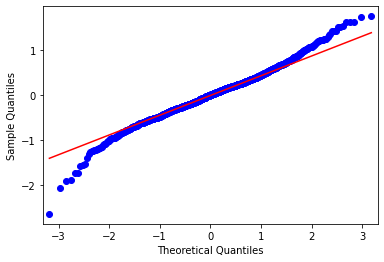

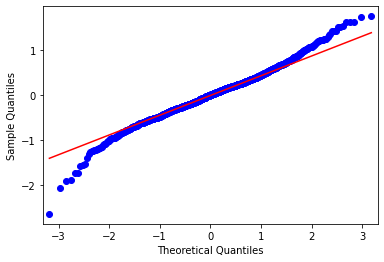

In [56]:
qqplot(lux_model2.resid, line = 'q')

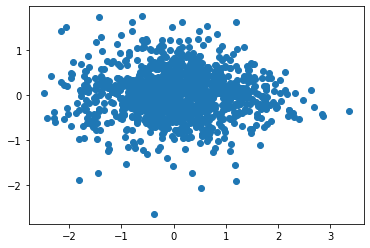

In [57]:
x = lux_model2.predict(lux_ols2.drop('price', axis = 1))
y = lux_model2.resid
plt.scatter(x, y);

In [58]:
lux_model2.resid.max()
x.max()

lux_ols2.loc[x[x == x.min()].index] ##the falsely-labeled home is one of the biggest outliers in this data set

#data.loc[y[y == y.max()].index]

,price,sqft_living,sqft_lot15,built_1,built_2,built_3,built_4,built_5,built_6,built_7,...,built_10,built_11,water_1,cond_4,cond_5,city_1,loc_2,loc_3,loc_4,loc_5
16083,-2.433469,-1.67686,0.481491,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Luxury Model 3

In [59]:
lux_ols3 = lux_ols_base[['price', 'waterfront', 'grade', 'sqft_living15', 'season_sold', 'unincorporated', 'location_cost']]


lux_ols3 = lux_ols3.drop(columns = ['waterfront', 'grade', 'season_sold', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols3 = pd.concat([lux_ols3, water_dummies, grade_dummies, season_dummies, inc_dummies, loc_dummies], axis = 1)

lux_ols3['price'] = power_price
lux_ols3['sqft_living15'] = power_sqft_living15

target = 'price'
x_cols = lux_ols3.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula3 = target + '~' + predictors

lux_model3 = ols(formula = formula3, data = lux_ols3).fit()
lux_model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     186.8
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          2.18e-290
Time:                        15:28:25   Log-Likelihood:                -1233.5
No. Observations:                1364   AIC:                             2495.
Df Residuals:                    1350   BIC:                             2568.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5576      0.066    -23.474      0.000      -1.688      -1.427
sqft_living15     0.1958      0.018     10.666      0.000       0.160       0.232
water_1           1.2036      0.123      9.755      0.000       0.962       1.446
grade_11          0.5133      0.040     12.702      0.000       0.434       0.593
grade_12          1.1401      0.079     14.401      0.000       0.985       1.295
grade_13          1.7773      0.203      8.754      0.000       1.379       2.176
month_spring      0.0896      0.046      1.946      0.052      -0.001       0.180
month_summer     -0.0161      0.046     -0.354      0.724      -0.106       0.073
month_winter      0.0273      0.054      0.508      0.612      -0.078       0.133
city_1           -0.0151      0.047     -0.322      0.747      -0.107       0.077
loc_2             1.0509      0.062     17.062      0.000       0.930       1.172
loc_3             1.9288      0.069     27.983      0.000       1.794       2.064
loc_4             2.4693      0.076     32.448      0.000       2.320       2.619
loc_5             2.9067      0.191     15.229      0.000       2.532       3.281
==============================================================================
Omnibus:                       49.252   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.147
Skew:                           0.022   Prob(JB):                     4.50e-30
Kurtosis:                       4.541   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

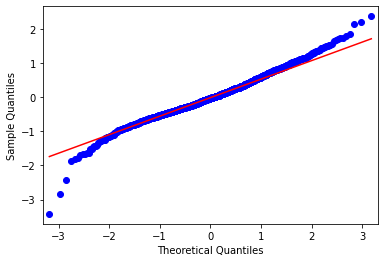

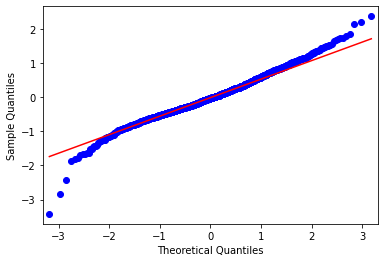

In [60]:
qqplot(lux_model3.resid, line = 'q')

## Luxury Model 4

In [61]:
lux_ols4 = lux_ols_base[['price', 'waterfront', 'grade', 'sqft_living15','location_cost']]


lux_ols4 = lux_ols4.drop(columns = ['waterfront', 'grade', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols4 = pd.concat([lux_ols4, water_dummies, grade_dummies, inc_dummies, loc_dummies], axis = 1)


scaled_lux_ols4 = pd.DataFrame(ss.fit_transform(lux_ols4))
scaled_lux_ols4.columns = lux_ols4.columns

scaled_lux_ols4['price'] = power_price
scaled_lux_ols4['sqft_living15'] = power_sqft_living15

scaled_lux_ols4

,price,sqft_living15,water_1,grade_11,grade_12,grade_13,city_1,loc_2,loc_3,loc_4,loc_5
0,0.406418,1.925749,-0.136641,1.766592,-0.230829,-0.081499,2.299068,0.819493,-0.499083,-0.358057,-0.090167
1,-0.003668,0.441326,-0.136641,1.766592,-0.230829,-0.081499,-0.434959,-1.220267,2.003673,-0.358057,-0.090167
2,-0.583744,0.074631,-0.136641,-0.566062,-0.230829,-0.081499,-0.434959,0.819493,-0.499083,-0.358057,-0.090167
3,0.135929,-0.868865,-0.136641,-0.566062,-0.230829,-0.081499,-0.434959,-1.220267,2.003673,-0.358057,-0.090167
4,-1.149917,-0.247368,-0.136641,-0.566062,-0.230829,-0.081499,2.299068,0.819493,-0.499083,-0.358057,-0.090167
...,...,...,...,...,...,...,...,...,...,...,...
1359,1.136993,-1.319146,-0.136641,-0.566062,-0.230829,-0.081499,-0.434959,-1.220267,-0.499083,2.792848,-0.090167
1360,-0.744185,-1.181400,-0.136641,-0.566062,-0.230829,-0.081499,-0.434959,0.819493,-0.499083,-0.358057,-0.090167
1361,0.386983,1.691448,-0.136641,1.766592,-0.230829,-0.081499,-0.434959,0.819493,-0.499083,-0.358057,-0.090167
1362,0.113375,-0.195466,-0.136641,-0.566062,-0.230829,-0.081499,-0.434959,0.819493,-0.499083,-0.358057,-0.090167


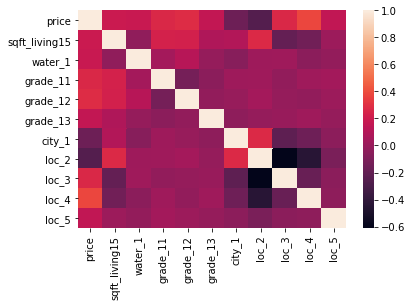

In [62]:
sns.heatmap(scaled_lux_ols4.corr());

In [63]:
target = 'price'
x_cols = lux_ols4.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula4 = target + '~' + predictors

lux_model4 = ols(formula = formula4, data = lux_ols4).fit()
lux_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     229.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          8.45e-283
Time:                        15:28:26   Log-Likelihood:                -19247.
No. Observations:                1364   AIC:                         3.852e+04
Df Residuals:                    1353   BIC:                         3.857e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.341e+05   4.98e+04      4.702      0.000    1.36e+05    3.32e+05
sqft_living15   120.7432     12.812      9.424      0.000      95.609     145.878
water_1        8.886e+05    6.7e+04     13.265      0.000    7.57e+05    1.02e+06
grade_11       2.422e+05    2.2e+04     11.030      0.000    1.99e+05    2.85e+05
grade_12       7.208e+05    4.3e+04     16.762      0.000    6.36e+05    8.05e+05
grade_13       1.437e+06    1.1e+05     13.032      0.000    1.22e+06    1.65e+06
city_1        -1.465e+04   2.54e+04     -0.576      0.565   -6.45e+04    3.52e+04
loc_2          2.589e+05   3.34e+04      7.743      0.000    1.93e+05    3.25e+05
loc_3          6.961e+05   3.74e+04     18.609      0.000    6.23e+05     7.7e+05
loc_4          1.065e+06   4.13e+04     25.793      0.000    9.84e+05    1.15e+06
loc_5           1.55e+06   1.04e+05     14.959      0.000    1.35e+06    1.75e+06
==============================================================================
Omnibus:                      429.079   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2376.081
Skew:                           1.352   Prob(JB):                         0.00
Kurtosis:                       8.873   Cond. No.                     4.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Luxury Model 5

In [64]:
lux_ols_base.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'yard_size', 'season_sold',
       'unincorporated', 'location_cost', 'decade_built'],
      dtype='object')

In [66]:
lux_ols5 = lux_ols_base[['price', 'sqft_living', 'sqft_living15','waterfront', 'condition','grade', 'location_cost', 'unincorporated']]

lux_ols5 = lux_ols5.drop(columns = ['waterfront', 'condition', 'grade', 'location_cost', 'unincorporated'], axis = 1) ##dropping original categoricals
lux_ols5 = pd.concat([lux_ols5, water_dummies, cond_dummies, grade_dummies, loc_dummies, inc_dummies], axis = 1)


lux_ols5['price'] = power_price
lux_ols5['sqft_living'] = power_sqft_living
lux_ols5['sqft_living15'] = power_sqft_living15

sts = StandardScaler()

lux_ols5_scaled = pd.DataFrame(sts.fit_transform(lux_ols5))
lux_ols5_scaled.columns = lux_ols5.columns

target = 'price'
x_cols = lux_ols5_scaled.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula9 = target + '~' + predictors

lux_model5 = ols(formula = formula9, data = lux_ols5_scaled).fit()
lux_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     340.7
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:28:46   Log-Likelihood:                -943.70
No. Observations:                1364   AIC:                             1915.
Df Residuals:                    1350   BIC:                             1988.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.939e-18      0.013  -5.28e-16      1.000      -0.026       0.026
sqft_living       0.4249      0.017     25.747      0.000       0.393       0.457
sqft_living15     0.0408      0.016      2.561      0.011       0.010       0.072
water_1           0.1420      0.013     10.592      0.000       0.116       0.168
cond_4            0.0316      0.013      2.351      0.019       0.005       0.058
cond_5            0.0885      0.014      6.550      0.000       0.062       0.115
grade_11          0.1133      0.015      7.664      0.000       0.084       0.142
grade_12          0.1340      0.015      9.091      0.000       0.105       0.163
grade_13          0.0748      0.014      5.505      0.000       0.048       0.102
loc_2             0.5700      0.025     23.211      0.000       0.522       0.618
loc_3             0.7490      0.022     33.420      0.000       0.705       0.793
loc_4             0.7536      0.020     38.288      0.000       0.715       0.792
loc_5             0.2426      0.014     17.562      0.000       0.216       0.270
city_1           -0.0320      0.014     -2.300      0.022      -0.059      -0.005
==============================================================================
Omnibus:                       52.611   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.799
Skew:                          -0.063   Prob(JB):                     8.05e-33
Kurtosis:                       4.608   Cond. No.                         3.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

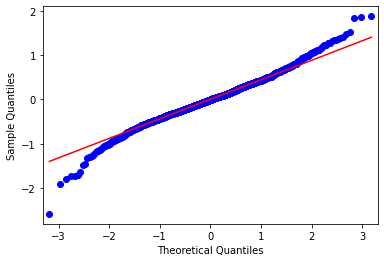

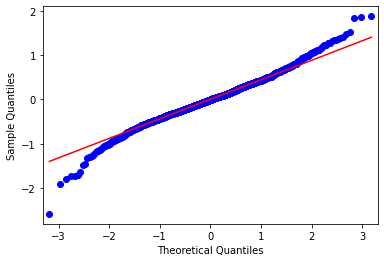

In [67]:
qqplot(lux_model5.resid, line = 'q')

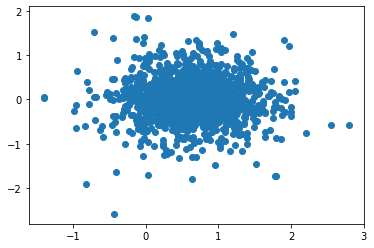

In [68]:
x = lux_model5.predict(lux_ols5.drop('price', axis = 1))
y = lux_model5.resid
plt.scatter(x, y);

## All homes of "occupiable" grade per King County Assessor

In [69]:
priced_df = data[(data['grade'] >= 6)]

priced_df.shape

(20840, 29)

In [70]:
##Initializing dummies for this DataFrame

dummy_list = ['unincorporated','waterfront','bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'season_sold', 'location_cost', 'decade_built']

inc_dummies2 = pd.get_dummies(priced_df['unincorporated'].astype(int), prefix='city', drop_first=True)
bed_dummies2 = pd.get_dummies(priced_df['bedrooms'].astype(int), prefix='bed', drop_first=True)
bath_dummies2 = pd.get_dummies(priced_df['bathrooms'].astype(int), prefix = 'bath', drop_first = True)
floor_dummies2 = pd.get_dummies(priced_df['floors'].astype(int), prefix='floor', drop_first=True)
cond_dummies2 = pd.get_dummies(priced_df['condition'].astype(int), prefix='cond', drop_first=True)
grade_dummies2 = pd.get_dummies(priced_df['grade'].astype(int), prefix='grade', drop_first=True)
season_dummies2 = pd.get_dummies(priced_df['season_sold'], prefix='month', drop_first=True)
loc_dummies2 = pd.get_dummies(priced_df['location_cost'].astype(int), prefix='loc', drop_first=True)
built_dummies2 = pd.get_dummies(priced_df['decade_built'].astype(int), prefix='built', drop_first=True)

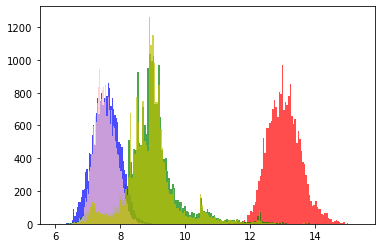

In [71]:
##Initialized log-transformed variables for all continuous variables without negative values

log_price2 = np.log(priced_df['price'])
log_sqft_living2 = np.log(priced_df['sqft_living'])
log_sqft_lot2 = np.log(priced_df['sqft_lot'])
log_sqft_living152 = np.log(priced_df['sqft_living15'])
log_sqft_lot152 = np.log(priced_df['sqft_lot15'])

plt.hist(log_price2, bins = 'auto', color = 'r', alpha = .7);
plt.hist(log_sqft_living2, bins = 'auto', color = 'b', alpha = .7);
plt.hist(log_sqft_lot2, bins = 'auto', color = 'g', alpha = .7);
plt.hist(log_sqft_living152, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(log_sqft_lot152, bins = 'auto', color = 'y', alpha = .7);

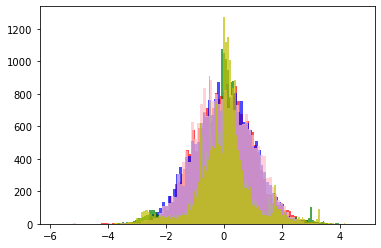

In [72]:
##Performed a Power Transformation on all continuous variable with no negative values

power = PowerTransformer()

power_price2 = power.fit_transform(np.array(log_price2).reshape(-1, 1))
power_sqft_living2 = power.fit_transform(np.array(log_sqft_living2).reshape(-1, 1))
power_sqft_lot2 = power.fit_transform(np.array(log_sqft_lot2).reshape(-1, 1))
power_sqft_living152 = power.fit_transform(np.array(log_sqft_living152).reshape(-1, 1))
power_sqft_lot152 = power.fit_transform(np.array(log_sqft_lot152).reshape(-1, 1))

plt.hist(power_price2, bins = 'auto', color = 'r', alpha = .7);
plt.hist(power_sqft_living2, bins = 'auto', color = 'b', alpha = .7);
plt.hist(power_sqft_lot2, bins = 'auto', color = 'g', alpha = .7);
plt.hist(power_sqft_living152, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(power_sqft_lot152, bins = 'auto', color = 'y', alpha = .7);

## All Homes Model 1

In [73]:
priced_ols1 = priced_df[['price', 'grade', 'sqft_living15', 'unincorporated', 'location_cost']]


priced_ols1 = priced_ols1.drop(columns = ['grade', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
priced_ols1 = pd.concat([priced_ols1, grade_dummies2, inc_dummies2, loc_dummies2], axis = 1)

priced_ols1['price'] = power_price2
priced_ols1['sqft_living15'] = power_sqft_living152

target = 'price'
x_cols = priced_ols1.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula5 = target + '~' + predictors

priced_model1 = ols(formula = formula5, data = priced_ols1).fit()
priced_model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     5689.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:32:18   Log-Likelihood:                -13780.
No. Observations:               20840   AIC:                         2.759e+04
Df Residuals:                   20826   BIC:                         2.770e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.4055      0.013   -109.376      0.000      -1.431      -1.380
sqft_living15     0.3133      0.005     69.396      0.000       0.304       0.322
grade_7           0.3746      0.012     30.657      0.000       0.351       0.399
grade_8           0.6898      0.014     50.319      0.000       0.663       0.717
grade_9           1.0650      0.017     63.199      0.000       1.032       1.098
grade_10          1.3722      0.021     65.274      0.000       1.331       1.413
grade_11          1.6885      0.030     56.939      0.000       1.630       1.747
grade_12          2.1204      0.057     37.363      0.000       2.009       2.232
grade_13          2.5529      0.157     16.222      0.000       2.244       2.861
city_1            0.0318      0.010      3.214      0.001       0.012       0.051
loc_2             0.8359      0.008    103.268      0.000       0.820       0.852
loc_3             1.4323      0.010    146.929      0.000       1.413       1.451
loc_4             1.7415      0.016    109.136      0.000       1.710       1.773
loc_5             2.1588      0.086     25.063      0.000       1.990       2.328
==============================================================================
Omnibus:                     1186.637   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4051.085
Skew:                          -0.216   Prob(JB):                         0.00
Kurtosis:                       5.116   Cond. No.                         61.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

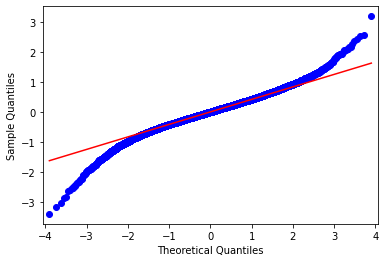

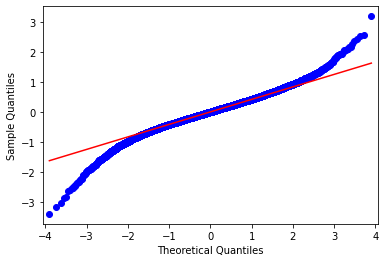

In [74]:
qqplot(priced_model1.resid, line = 'q')

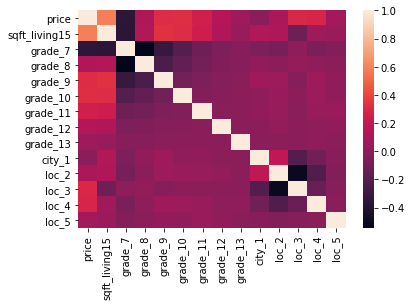

In [75]:
sns.heatmap(priced_ols1.corr());

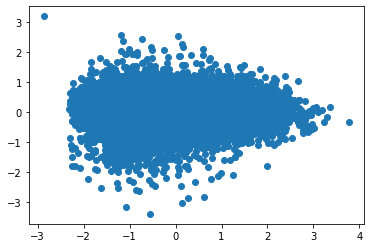

In [76]:
x = priced_model1.predict(priced_ols1.drop('price', axis = 1))
y = priced_model1.resid
plt.scatter(x, y);

In [77]:
df.loc[x[x == x.min()].index]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,price_per_sqft,yard_size,month_sold,season_sold,unincorporated,zip_psqft,location_cost,decade_built
13428,2722059275,5/12/2015,536000.0,3,2.75,2290,34548,2.0,0.0,3.0,...,399,275299,234.061135,32258.0,5,spring,0,164.377517,1.0,8.0


## All Homes Model 2

In [78]:
priced_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_per_sqft',
       'yard_size', 'month_sold', 'season_sold', 'unincorporated', 'zip_psqft',
       'location_cost', 'decade_built'],
      dtype='object')

In [79]:
priced_ols2 = priced_df[['price','grade','sqft_living', 'sqft_living15', 'location_cost']]


priced_ols2 = priced_ols2.drop(columns = ['grade', 'location_cost'], axis = 1) ##dropping original categoricals
priced_ols2 = pd.concat([priced_ols2, grade_dummies2, loc_dummies2], axis = 1)

priced_ols2['price'] = power_price2
priced_ols2['sqft_living'] = power_sqft_living2
priced_ols2['sqft_living15'] = power_sqft_living152

target = 'price'
x_cols = priced_ols2.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula6 = target + '~' + predictors

priced_model2 = ols(formula = formula6, data = priced_ols2).fit()
priced_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     7739.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:32:33   Log-Likelihood:                -11199.
No. Observations:               20840   AIC:                         2.243e+04
Df Residuals:                   20826   BIC:                         2.254e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.1211      0.012    -94.573      0.000      -1.144      -1.098
sqft_living       0.3725      0.005     76.602      0.000       0.363       0.382
sqft_living15     0.1429      0.005     31.324      0.000       0.134       0.152
grade_7           0.1650      0.011     14.818      0.000       0.143       0.187
grade_8           0.3527      0.013     27.363      0.000       0.327       0.378
grade_9           0.5904      0.016     36.601      0.000       0.559       0.622
grade_10          0.7821      0.020     38.902      0.000       0.743       0.822
grade_11          0.9759      0.028     35.100      0.000       0.921       1.030
grade_12          1.2801      0.051     24.945      0.000       1.180       1.381
grade_13          1.4911      0.140     10.673      0.000       1.217       1.765
loc_2             0.8467      0.007    118.503      0.000       0.833       0.861
loc_3             1.4553      0.009    170.832      0.000       1.439       1.472
loc_4             1.7645      0.014    125.820      0.000       1.737       1.792
loc_5             2.0826      0.076     27.373      0.000       1.934       2.232
==============================================================================
Omnibus:                     1478.945   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4918.068
Skew:                          -0.331   Prob(JB):                         0.00
Kurtosis:                       5.286   Cond. No.                         65.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

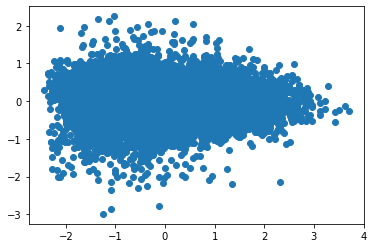

In [80]:
x = priced_model2.predict(priced_ols2.drop('price', axis = 1))
y = priced_model2.resid
plt.scatter(x, y);

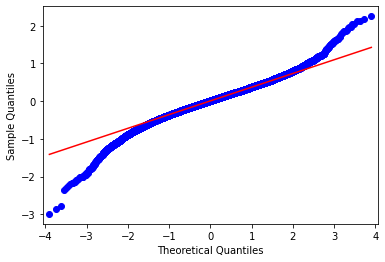

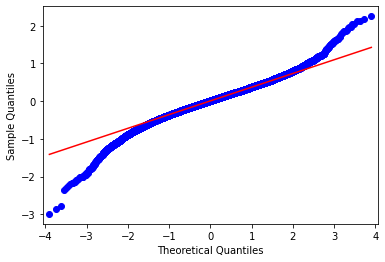

In [81]:
qqplot(priced_model2.resid, line = 'q')

## Non-Luxury Subset

In [82]:
nonlux_df = data[(data['grade'] >=6) & (data['grade'] < 10)]

to_drop = ['date', 'view', 'yr_renovated', 'zipcode', 'lat', 'long', 'price_per_sqft', 'month_sold', 'zip_psqft', 'sqft_above', 'yr_built', 'yard_size']
nonlux_df = nonlux_df.drop(columns = to_drop, axis =1)

nonlux_df.dropna(inplace = True)

In [83]:
abs(nonlux_df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,sqft_living15,sqft_lot15,unincorporated,location_cost,decade_built
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [84]:
##Dummy Variables for this subset

dummy_list = ['unincorporated','waterfront','bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'season_sold', 'location_cost', 'decade_built']

inc_dummies3 = pd.get_dummies(nonlux_df['unincorporated'].astype(int), prefix='city', drop_first=True)
bed_dummies3 = pd.get_dummies(nonlux_df['bedrooms'].astype(int), prefix='bed', drop_first=True)
bath_dummies3 = pd.get_dummies(nonlux_df['bathrooms'].astype(int), prefix = 'bath', drop_first = True)
floor_dummies3 = pd.get_dummies(nonlux_df['floors'].astype(int), prefix='floor', drop_first=True)
cond_dummies3 = pd.get_dummies(nonlux_df['condition'].astype(int), prefix='cond', drop_first=True)
grade_dummies3 = pd.get_dummies(nonlux_df['grade'].astype(int), prefix='grade', drop_first=True)
season_dummies3 = pd.get_dummies(nonlux_df['season_sold'], prefix='month', drop_first=True)
loc_dummies3 = pd.get_dummies(nonlux_df['location_cost'].astype(int), prefix='loc', drop_first=True)
built_dummies3 = pd.get_dummies(nonlux_df['decade_built'].astype(int), prefix='built', drop_first=True)


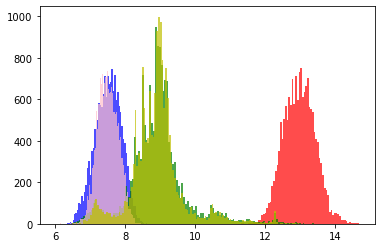

In [85]:
## Log transformation for non-negative continuous variables

log_price3 = np.log(nonlux_df['price'])
log_sqft_living3 = np.log(nonlux_df['sqft_living'])
log_sqft_lot3 = np.log(nonlux_df['sqft_lot'])
log_sqft_living153 = np.log(nonlux_df['sqft_living15'])
log_sqft_lot153 = np.log(nonlux_df['sqft_lot15'])

plt.hist(log_price3, bins = 'auto', color = 'r', alpha = .7);
plt.hist(log_sqft_living3, bins = 'auto', color = 'b', alpha = .7);
plt.hist(log_sqft_lot3, bins = 'auto', color = 'g', alpha = .7);
plt.hist(log_sqft_living153, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(log_sqft_lot153, bins = 'auto', color = 'y', alpha = .7);

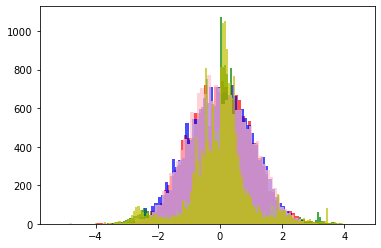

In [86]:
## Power transformation to normalize and center continuous variables 
power = PowerTransformer()

power_price3 = power.fit_transform(np.array(log_price3).reshape(-1, 1))
power_sqft_living3 = power.fit_transform(np.array(log_sqft_living3).reshape(-1, 1))
power_sqft_lot3 = power.fit_transform(np.array(log_sqft_lot3).reshape(-1, 1))
power_sqft_living153 = power.fit_transform(np.array(log_sqft_living153).reshape(-1, 1))
power_sqft_lot153 = power.fit_transform(np.array(log_sqft_lot153).reshape(-1, 1))

plt.hist(power_price3, bins = 'auto', color = 'r', alpha = .7);
plt.hist(power_sqft_living3, bins = 'auto', color = 'b', alpha = .7);
plt.hist(power_sqft_lot3, bins = 'auto', color = 'g', alpha = .7);
plt.hist(power_sqft_living153, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(power_sqft_lot153, bins = 'auto', color = 'y', alpha = .7);

In [87]:
nonlux_ols = nonlux_df[['price','grade', 'sqft_living15', 'location_cost']]

nonlux_ols = nonlux_ols.drop(columns = ['grade', 'location_cost'], axis = 1) ##dropping original categoricals
nonlux_ols = pd.concat([nonlux_ols, grade_dummies3, loc_dummies3], axis = 1)

nonlux_ols['price'] = power_price3
nonlux_ols['sqft_living15'] = power_sqft_living153

target = 'price'
x_cols = nonlux_ols.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula7 = target + '~' + predictors

nonlux_model = ols(formula = formula7, data = nonlux_ols).fit()
nonlux_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     5909.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:33:12   Log-Likelihood:                -12565.
No. Observations:               16777   AIC:                         2.515e+04
Df Residuals:                   16768   BIC:                         2.522e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.4045      0.015    -94.921      0.000      -1.433      -1.375
sqft_living15     0.3262      0.005     64.635      0.000       0.316       0.336
grade_7           0.3807      0.014     26.618      0.000       0.353       0.409
grade_8           0.7171      0.016     44.546      0.000       0.686       0.749
grade_9           1.1459      0.020     57.281      0.000       1.107       1.185
loc_2             0.9062      0.010     93.957      0.000       0.887       0.925
loc_3             1.5532      0.012    134.607      0.000       1.531       1.576
loc_4             1.9414      0.020     97.767      0.000       1.902       1.980
loc_5             2.5605      0.128     19.951      0.000       2.309       2.812
==============================================================================
Omnibus:                      666.298   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2100.509
Skew:                          -0.051   Prob(JB):                         0.00
Kurtosis:                       4.730   Cond. No.                         41.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

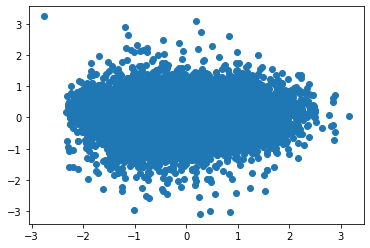

In [88]:
x = nonlux_model.predict(nonlux_ols.drop('price', axis = 1))
y = nonlux_model.resid
plt.scatter(x, y);

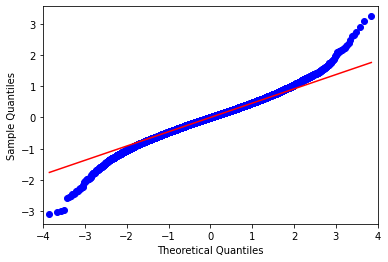

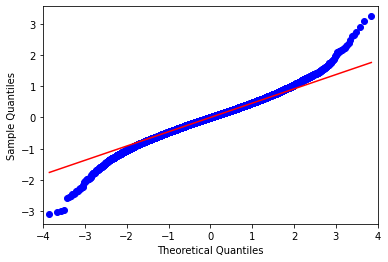

In [89]:
qqplot(nonlux_model.resid, line = 'q')

## Non-Luxury Model 2

In [90]:
nonlux_ols2 = nonlux_df[['sqft_living', 'sqft_living15', 'sqft_lot','condition', 'grade', 'location_cost']]

nonlux_ols2 = nonlux_ols2.drop(columns = ['condition', 'grade', 'location_cost'], axis = 1) ##dropping original categoricals
nonlux_ols2 = pd.concat([nonlux_ols2, cond_dummies3, grade_dummies3, loc_dummies3], axis = 1)

nonlux_ols2['price'] = power_price3
nonlux_ols2['sqft_living'] = power_sqft_living3
nonlux_ols2['sqft_living15'] = power_sqft_living153
nonlux_ols2['sqft_lot'] = power_sqft_lot3

target = 'price'
x_cols = nonlux_ols2.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula8 = target + '~' + predictors

nonlux_model2 = ols(formula = formula8, data = nonlux_ols2).fit()
nonlux_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     5774.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:33:19   Log-Likelihood:                -10084.
No. Observations:               16777   AIC:                         2.019e+04
Df Residuals:                   16764   BIC:                         2.030e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2739      0.014    -90.344      0.000      -1.302      -1.246
sqft_living       0.3371      0.005     63.185      0.000       0.327       0.348
sqft_living15     0.1284      0.005     24.734      0.000       0.118       0.139
sqft_lot          0.0789      0.004     18.997      0.000       0.071       0.087
cond_4            0.0814      0.008     10.052      0.000       0.066       0.097
cond_5            0.2347      0.013     18.102      0.000       0.209       0.260
grade_7           0.2214      0.013     17.262      0.000       0.196       0.246
grade_8           0.4778      0.015     31.417      0.000       0.448       0.508
grade_9           0.7711      0.019     40.310      0.000       0.734       0.809
loc_2             0.9171      0.008    109.962      0.000       0.901       0.933
loc_3             1.6251      0.011    153.862      0.000       1.604       1.646
loc_4             2.0350      0.018    115.131      0.000       2.000       2.070
loc_5             2.4952      0.111     22.534      0.000       2.278       2.712
==============================================================================
Omnibus:                      869.806   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2608.063
Skew:                          -0.232   Prob(JB):                         0.00
Kurtosis:                       4.875   Cond. No.                         45.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
nonlux_df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,sqft_living15,sqft_lot15,unincorporated,location_cost,decade_built
id,1.000000,0.002012,0.008704,0.026662,0.005588,-0.135381,0.027636,-0.005224,-0.023088,0.029630,-0.005388,0.007559,-0.147090,0.003463,0.004000,0.026238
price,0.002012,1.000000,0.293247,0.417408,0.603376,0.060552,0.225574,0.126409,0.083919,0.566616,0.300753,0.513417,0.046648,-0.034448,0.596229,-0.040950
bedrooms,0.008704,0.293247,1.000000,0.491086,0.605968,0.019179,0.137159,-0.011122,0.027233,0.304493,0.296942,0.374809,0.013508,-0.016847,-0.040224,0.119652
bathrooms,0.026662,0.417408,0.491086,1.000000,0.687578,0.040257,0.489407,0.023274,-0.135929,0.582192,0.226120,0.491203,0.039281,0.128512,0.012321,0.498944
sqft_living,0.005588,0.603376,0.605968,0.687578,1.000000,0.135075,0.300012,0.045793,-0.037890,0.642577,0.428558,0.704496,0.144791,0.109153,0.022497,0.272344
sqft_lot,-0.135381,0.060552,0.019179,0.040257,0.135075,1.000000,-0.034193,0.032982,0.012804,0.062867,0.005546,0.138159,0.748555,0.252829,-0.111580,0.037727
floors,0.027636,0.225574,0.137159,0.489407,0.300012,-0.034193,1.000000,0.000561,-0.284019,0.440372,-0.299813,0.219689,-0.041577,0.136647,0.105932,0.484644
waterfront,-0.005224,0.126409,-0.011122,0.023274,0.045793,0.032982,0.000561,1.000000,0.021616,0.021618,0.052113,0.038264,0.037878,0.023378,-0.019174,-0.036279
condition,-0.023088,0.083919,0.027233,-0.135929,-0.037890,0.012804,-0.284019,0.021616,1.000000,-0.160888,0.192292,-0.085684,0.014223,-0.121766,0.068742,-0.386162
grade,0.029630,0.566616,0.304493,0.582192,0.642577,0.062867,0.440372,0.021618,-0.160888,1.000000,0.096771,0.615512,0.068264,0.074818,0.129218,0.438744


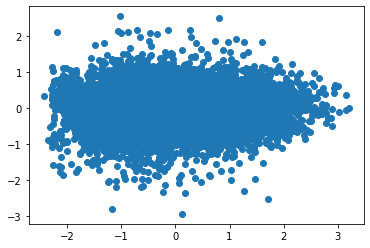

In [92]:
x = nonlux_model2.predict(nonlux_ols2.drop('price', axis = 1))
y = nonlux_model2.resid
plt.scatter(x, y);

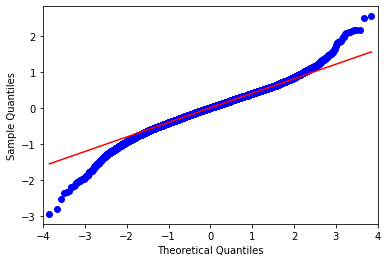

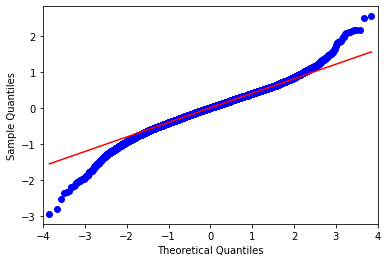

In [93]:
qqplot(nonlux_model2.resid, line = 'q')

# Geopandas Plotting

In [ ]:
import geopandas as gpd